In [1]:
# do not run when we import this package as module
if __name__ == '__main__':
  # Connect Google Drive
  from google.colab import drive
  drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
# Common
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls
import datetime
from collections import Counter

# Data
from tqdm import tqdm
from glob import glob
import tensorflow.data as tfd

# Data Visualization
import cv2
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import applications as tka
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [4]:
# Clear any logs from previous runs
!rm -rf /content/gdrive/MyDrive/OWR/log/OCR_Model4/

In [4]:
!pip install keras_tuner
import keras_tuner as kt
cls()

In [5]:
!pip install opendatasets
cls()

In [6]:
import opendatasets as od

# Specify the Kaggle dataset URL
dataset_url = 'https://www.kaggle.com/datasets/munemshahriar642/english-typed-font-in-csv/data?select=typedCSV.csv'

# Download the dataset to the specified folder
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sachithgunawardane
Your Kaggle Key: ··········


100%|██████████| 28.0M/28.0M [00:01<00:00, 17.9MB/s]


In [7]:
# The batch size
BATCH_SIZE = 64

# Image dims
ORG_IMAGE_SIZE = (28,28)
IMAGE_SIZE = (64,64)

# Buffer size
BUFFER = 1000

# Autotuning
AUTOTUNE = tfd.AUTOTUNE

In [8]:
# Setting the Random Seeds
np.random.seed(1024)
tf.random.set_seed(1024)

In [34]:
# Specify the root paths
dataset_csv_path = '/content/english-typed-font-in-csv/typedCSV.csv'

tensorboard_log_dir = '/content/gdrive/MyDrive/OWR/log/OCR_Model4/'
model_dir = '/content/gdrive/MyDrive/OWR/dl_models/OCR_Model4/'
figure_dir = '/content/gdrive/MyDrive/OWR/figures/OCR_Model4/'

In [10]:
df = pd.read_csv(dataset_csv_path)

In [11]:
df.head(5)

,label,pixel 0,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,...,pixel 774,pixel 775,pixel 776,pixel 777,pixel 778,pixel 779,pixel 780,pixel 781,pixel 782,pixel 783
0,0,255,255,255,255,255,255,255,255,253,...,250,255,255,251,255,255,255,255,255,255
1,0,255,255,255,255,255,255,255,255,255,...,254,255,255,255,249,253,255,255,255,255
2,0,255,255,255,255,255,255,255,255,254,...,255,255,255,255,255,255,255,255,255,255
3,0,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,0,255,253,255,253,251,255,254,255,255,...,255,255,253,253,255,255,255,255,255,255


In [12]:
df.loc[df['label'] >= 36, 'label'] = df['label']  - 26

In [13]:
# Get all label claasified with capital letters
df['label'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [6]:
class_names = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F',
               'G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V',
               'W','X','Y','Z']
n_classes = len(class_names)

In [15]:
# Reshape and normalize data
X_train = df.iloc[:,1:].values.reshape(df.shape[0],*ORG_IMAGE_SIZE,1).astype('float32')
X_train = np.repeat(np.uint8(X_train), 3, axis=-1)
X_train = np.array([cv2.resize(img, (64, 64)) for img in X_train])
X_train = X_train / 255.0

y_train = df.iloc[:,0].values

In [16]:
LabelB = LabelEncoder()
Y_labels_encoded = LabelB.fit_transform(y_train)
Y_H_E = to_categorical(Y_labels_encoded)

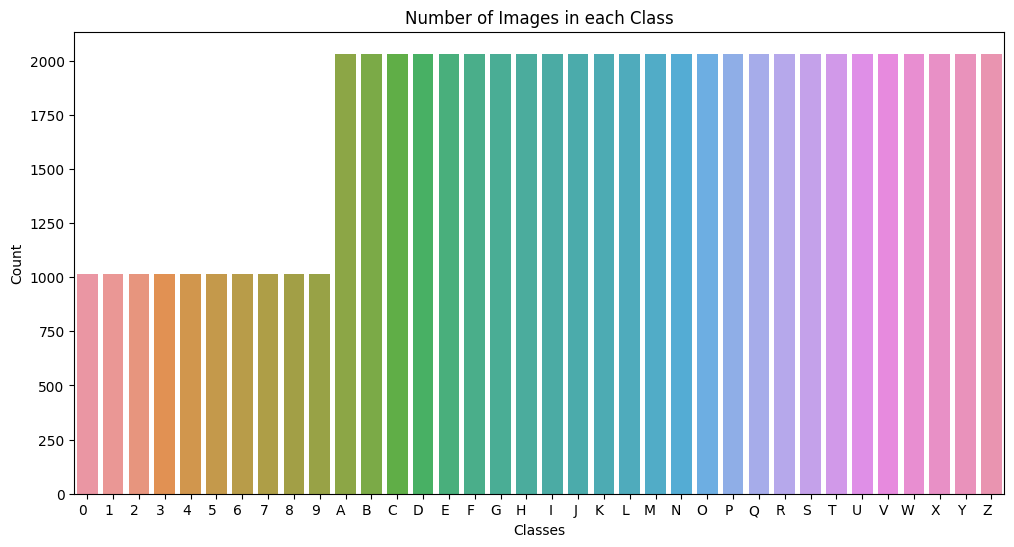

In [18]:
def his_class_record_count(Y, classes):
  class_names_from_indices = np.vectorize(lambda x: classes[x])(np.argmax(Y, axis=1))

  # Find unique elements and their counts
  unique_elements, counts = np.unique(class_names_from_indices, return_counts=True)

  # Plot the histogram
  plt.figure(figsize=(12, 6))
  sns.barplot(x=unique_elements, y=counts)
  plt.title('Number of Images in each Class')
  plt.xlabel('Classes')
  plt.ylabel('Count')
  plt.xticks(ha='right')
  plt.show()

his_class_record_count(Y_H_E, class_names)

In [17]:
#train_size is 1 - tst_size - vld_size
tst_size=0.15
vld_size=0.15

X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_H_E, test_size = vld_size, random_state=1024)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=tst_size, random_state=1024)

In [18]:
print(f"Training Data Size   : {len(X_train)}")
print(f"Validation Data Size : {len(X_valid)}")
print(f"Testing Data Size    : {len(X_test)}")

Training Data Size   : 45511
Validation Data Size : 9449
Testing Data Size    : 8032


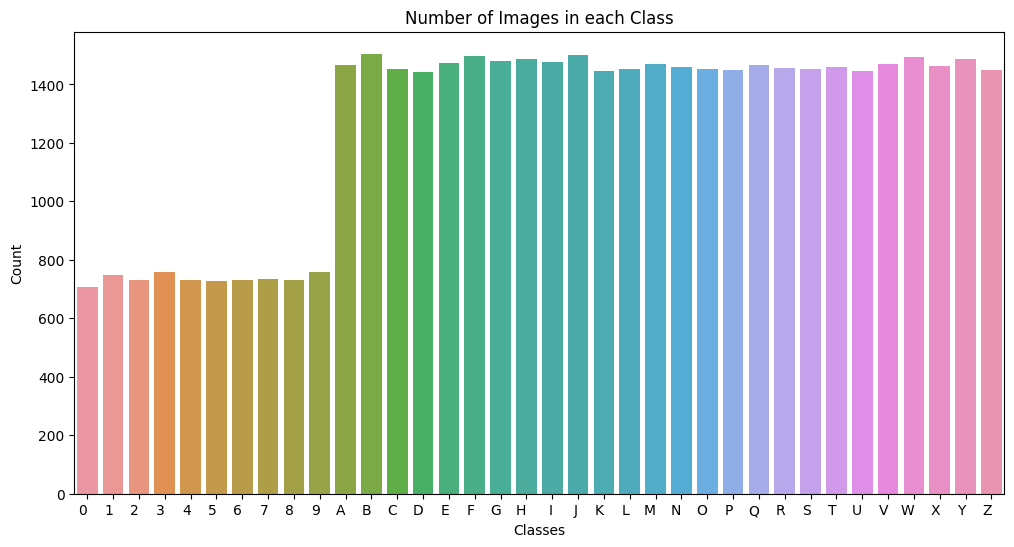

In [21]:
his_class_record_count(y_train, class_names)

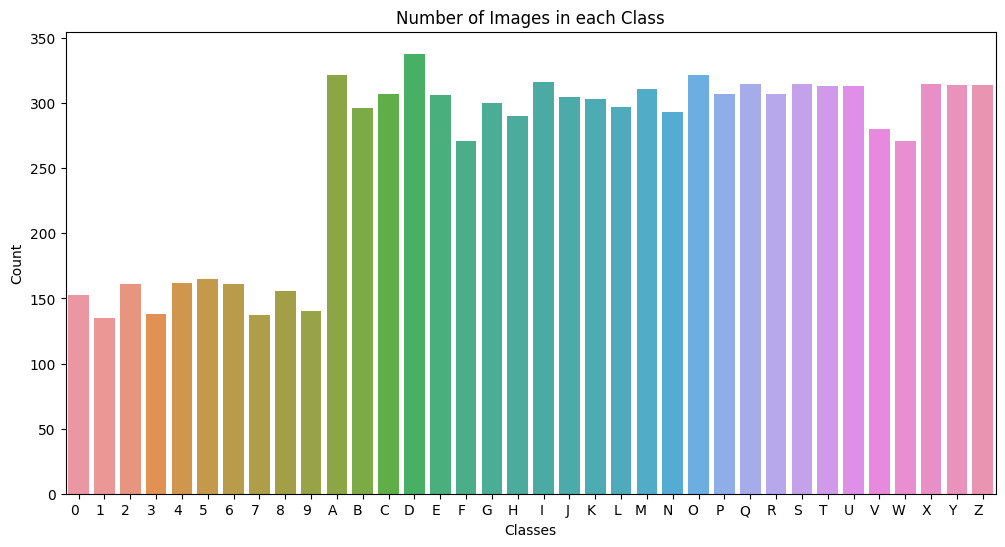

In [22]:
his_class_record_count(y_valid, class_names)

In [23]:
def display_images(images, labels, classes, no_of_imgs):
  indices_to_display = np.random.choice(images.shape[0], no_of_imgs, replace=False)
  # Set up the Seaborn grid layout
  sns.set(style="whitegrid")

  # Create a figure and axes to display the images
  fig, axes = plt.subplots(4, 5, figsize=(10, 8))

  for i, ax in enumerate(axes.flatten()):
    index = indices_to_display[i]
    image = images[index, :, :]

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(classes[np.argmax(labels[index])])

  plt.tight_layout()
  plt.show()

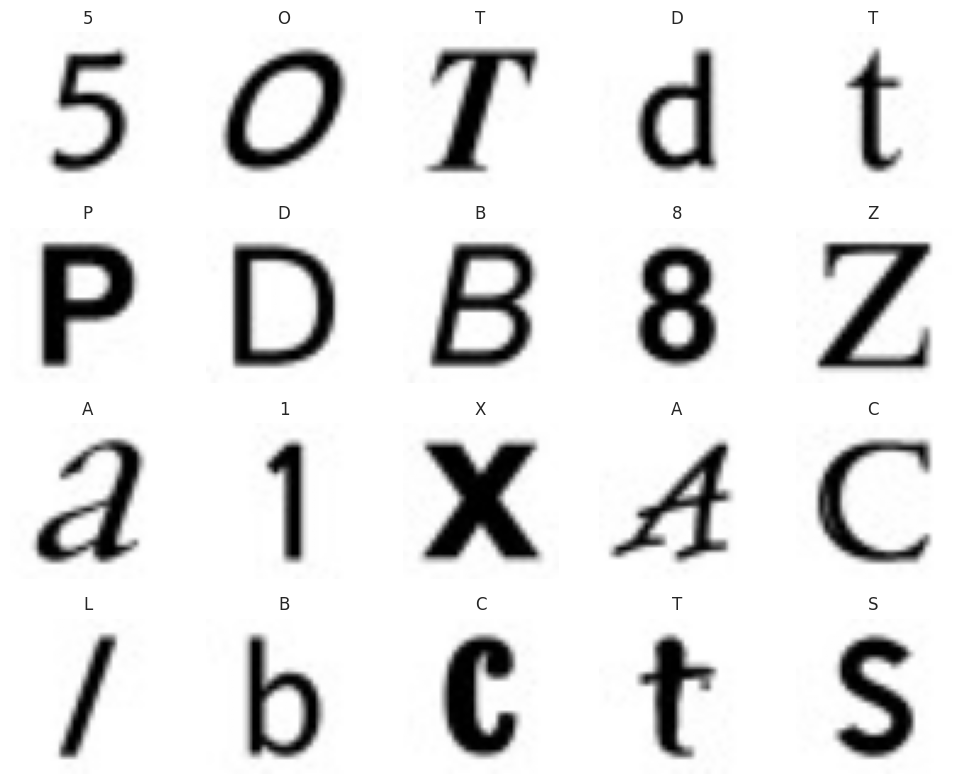

In [24]:
display_images(X_train, y_train, class_names, 20 )

In [31]:
def build_model():

  # Initialize the model in sequential
  model = keras.Sequential()
  # Adding first convolutional layer
  model.add(layers.Conv2D(
      filters=128,
      kernel_size=3,
      activation='relu',
      input_shape=(*IMAGE_SIZE,3)
  ))
  # Adding first pooling layer
  model.add(layers.MaxPool2D(
      pool_size=(2,2)
  ))

  # Adding multiple convolutional and pooling layers
  model.add(layers.Conv2D(
      filters=64,
      kernel_size=5,
      activation='relu',
  ))
  model.add(layers.MaxPool2D(
      pool_size=(3,2)
  ))
  model.add(layers.Conv2D(
      filters=64,
      kernel_size=3,
      activation='relu',
  ))
  model.add(layers.MaxPool2D(
      pool_size=(3,3)
  ))


  model.add(layers.GlobalAveragePooling2D())

  # Adding multiple FC layers

  model.add(layers.Dense(128,
                          activation='relu'))
  model.add(layers.Dropout(0.5))


  #model.add(layers.BatchNormalization())

  # Adding output layer
  model.add(layers.Dense(n_classes, activation='softmax'))


  # Compile the model
  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(0.001),
                metrics=['accuracy'])


  return model

In [32]:
model = build_model()

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 62, 62, 128)       3584      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 31, 31, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 27, 27, 64)        204864    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 9, 13, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 11, 64)         36928     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 2, 3, 64)         

In [35]:
# Training the model
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=100,
                    callbacks = [
        callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint(f'{model_dir}model_ocr_v4_1.h5', save_best_only=True),
        callbacks.TensorBoard(f'{tensorboard_log_dir}{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}', histogram_freq=1)
    ]
)

Epoch 1/100
1423/1423 [==============================] - 28s 13ms/step - loss: 1.8205 - accuracy: 0.4840 - val_loss: 0.6292 - val_accuracy: 0.8316
Epoch 2/100
   1/1423 [..............................] - ETA: 18s - loss: 0.9440 - accuracy: 0.6875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1423/1423 [==============================] - 17s 12ms/step - loss: 0.7236 - accuracy: 0.7937 - val_loss: 0.4558 - val_accuracy: 0.8764
Epoch 3/100
1423/1423 [==============================] - 17s 12ms/step - loss: 0.5607 - accuracy: 0.8382 - val_loss: 0.3762 - val_accuracy: 0.8901
Epoch 4/100
1423/1423 [==============================] - 17s 12ms/step - loss: 0.4828 - accuracy: 0.8618 - val_loss: 0.3334 - val_accuracy: 0.9005
Epoch 5/100
1423/1423 [==============================] - 17s 12ms/step - loss: 0.4382 - accuracy: 0.8711 - val_loss: 0.3175 - val_accuracy: 0.9045
Epoch 6/100
1423/1423 [==============================] - 17s 12ms/step - loss: 0.3941 - accuracy: 0.8838 - val_loss: 0.3042 - val_accuracy: 0.9101
Epoch 7/100
1423/1423 [==============================] - 17s 12ms/step - loss: 0.3696 - accuracy: 0.8920 - val_loss: 0.2673 - val_accuracy: 0.9212
Epoch 8/100
1423/1423 [==============================] - 17s 12ms/step - loss: 0.3446 - accuracy: 0.8976 - val_loss: 0.2527 - val_

In [37]:
# Valid Data
score = model.evaluate(X_valid, y_valid)

print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

296/296 [==============================] - 1s 4ms/step - loss: 0.1502 - accuracy: 0.9540
Validation loss: 0.1502150297164917
Validation accuracy: 0.9539633989334106


In [39]:
# Test data
score = model.evaluate(X_test, y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

251/251 [==============================] - 1s 4ms/step - loss: 0.1509 - accuracy: 0.9548
Test loss: 0.15092064440250397
Test accuracy: 0.9548057913780212


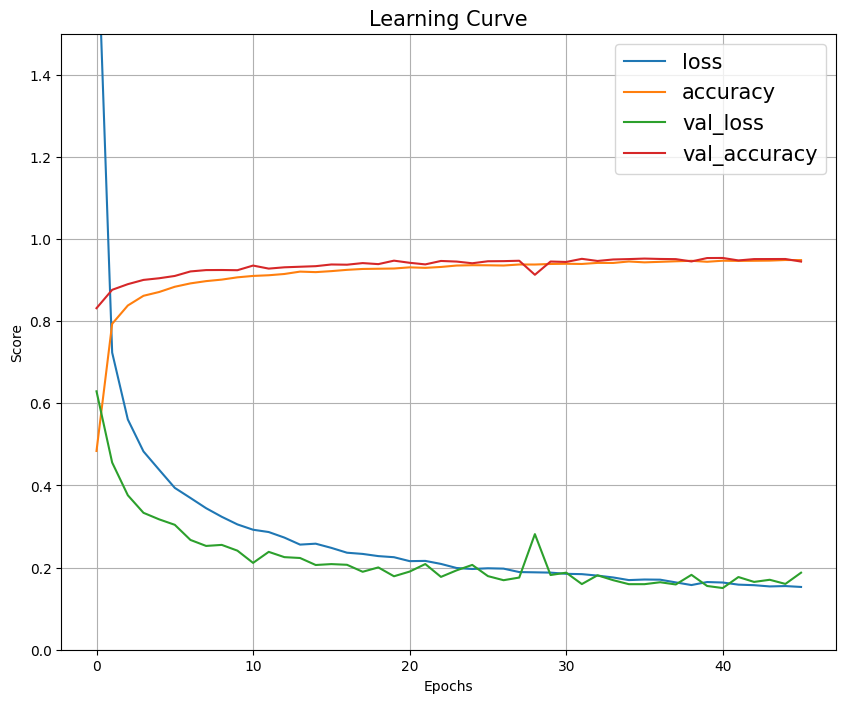

In [40]:
pd.DataFrame(history.history).plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=15)
plt.legend(fontsize=15)
plt.ylim([0,1.5])
plt.ylabel('Score')
plt.xlabel('Epochs')
plt.grid()
plt.show()

## Testing

In [3]:
model_path = '/content/gdrive/MyDrive/OWR/dl_models/OCR_Model4/model_ocr_v4_1.h5'
model_verification = keras.models.load_model(model_path)

model_verification.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 62, 62, 128)       3584      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 31, 31, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 27, 27, 64)        204864    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 9, 13, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 11, 64)         36928     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 2, 3, 64)         

(64, 64, 3)
1/1 [==============================] - 0s 47ms/step
5


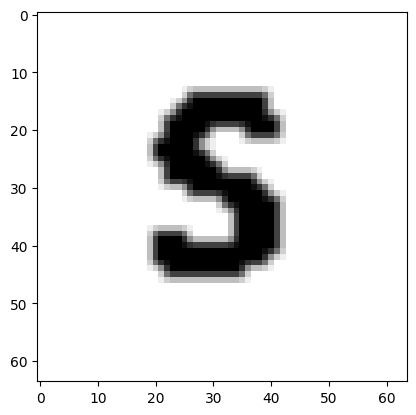

In [29]:
#img = Image.open('/content/gdrive/MyDrive/OWR/data/tmpCharacterSegment3/character_13.png')
img = cv2.imread('/content/gdrive/MyDrive/OWR/data/tmpCharacterSegment3/character_15.png', cv2.IMREAD_GRAYSCALE)

 # Resize image
#img = img.resize((64,64), Image.ANTIALIAS)
img = cv2.resize(img, (64, 64))
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Convert to NumPy array
img_array = np.array(img)

# Normalize by dividing by 255
img_array = img_array / 255.0
print(img_array.shape)
plt.imshow(img_array, cmap='gray')

image = tf.expand_dims((img_array), axis=0)
pred = model_verification.predict(image)[0]
max_index = tf.argmax(pred)
score = pred[max_index]
pred_label = class_names[max_index]
print(pred_label)

In [14]:
print(np.max(pred))

0.999833


In [15]:
pred

array([0.0000000e+00, 7.6534779e-09, 4.8947257e-23, 5.8761483e-15,
       2.5199310e-26, 5.6601268e-20, 0.0000000e+00, 4.5601200e-06,
       0.0000000e+00, 2.1623356e-20, 6.0790356e-20, 3.5833893e-26,
       2.0725034e-29, 1.7622904e-20, 1.0168322e-26, 2.4328603e-11,
       9.5050820e-18, 1.6322792e-27, 9.9983299e-01, 1.6162613e-04,
       2.8846211e-34, 4.7730383e-12, 0.0000000e+00, 1.8044751e-19,
       2.1307616e-35, 5.6689663e-27, 2.1491620e-27, 1.7069398e-17,
       3.5539443e-18, 7.8276634e-07, 4.5011919e-22, 4.3045234e-18,
       1.6603544e-38, 7.9065566e-23, 2.1741873e-21, 4.6796122e-12],
      dtype=float32)